# Gradient Boosting Demo: All Three Engines

This notebook demonstrates the `boost_tree()` model specification with all three supported engines:
- **XGBoost**: Fast, scalable gradient boosting
- **LightGBM**: Microsoft's efficient gradient boosting framework
- **CatBoost**: Yandex's gradient boosting with excellent categorical support

## Key Features:
- Unified API across all engines
- 8 tunable parameters
- Feature importance extraction
- Early stopping support
- Comprehensive performance metrics
- Side-by-side engine comparison

In [41]:
!pip install -e .

Obtaining file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/examples
ERROR: file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/examples does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from py_parsnip import boost_tree
from py_workflows import workflow
from py_rsample import initial_split, vfold_cv
from py_tune import tune, tune_grid, grid_regular, finalize_workflow
from py_yardstick import metric_set, rmse, mae, r_squared
import time

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Introduction to Gradient Boosting

Gradient boosting builds an ensemble of weak learners (typically decision trees) sequentially, where each new tree tries to correct the errors of the previous ones.

### The 8 Tunable Parameters in boost_tree():

1. **trees**: Number of boosting iterations (n_estimators)
2. **tree_depth**: Maximum tree depth
3. **learn_rate**: Step size shrinkage (0 to 1)
4. **mtry**: Number of features to sample per split
5. **min_n**: Minimum samples in leaf node
6. **loss_reduction**: Minimum loss reduction for split
7. **sample_size**: Fraction of observations per tree (0 to 1)
8. **stop_iter**: Early stopping rounds

### Engine-Specific Parameter Mappings:

| Parameter | XGBoost | LightGBM | CatBoost |
|-----------|---------|----------|----------|
| trees | n_estimators | n_estimators | iterations |
| tree_depth | max_depth | max_depth | depth |
| learn_rate | learning_rate | learning_rate | learning_rate |
| mtry | colsample_bytree | colsample_bytree | rsm |
| min_n | min_child_weight | min_data_in_leaf | min_data_in_leaf |
| loss_reduction | gamma | min_split_gain | (not supported) |
| sample_size | subsample | subsample | subsample |
| stop_iter | early_stopping_rounds | early_stopping_rounds | early_stopping_rounds |

## 2. Generate Sample Data

Create a synthetic regression dataset with non-linear relationships that benefit from gradient boosting.

In [43]:
# Generate synthetic data with non-linear relationships
n = 500
data = pd.DataFrame({
    'x1': np.random.uniform(0, 10, n),
    'x2': np.random.uniform(0, 10, n),
    'x3': np.random.uniform(0, 10, n),
    'x4': np.random.uniform(0, 10, n),
    'x5': np.random.uniform(0, 10, n),
    'x6': np.random.randint(0, 5, n),  # Categorical-like
})

# Create target with complex non-linear relationships
data['y'] = (
    2 * data['x1'] +
    3 * np.sin(data['x2']) +
    0.5 * data['x3'] ** 2 +
    1.5 * np.log(data['x4'] + 1) +
    0.8 * data['x5'] * data['x6'] +
    np.random.normal(0, 2, n)
)

print("Data shape:", data.shape)
print("\nFirst few rows:")
print(data.head())
print("\nTarget statistics:")
print(data['y'].describe())

Data shape: (500, 7)

First few rows:
         x1        x2        x3        x4        x5  x6          y
0  3.745401  6.981617  1.851329  5.190818  2.617057   2  17.098322
1  9.507143  5.360964  5.419009  4.791819  2.469788   3  41.783897
2  7.319939  3.095276  8.729458  0.256421  9.062546   4  84.297142
3  5.986585  8.137950  7.322249  3.412478  2.495462   2  49.361263
4  1.560186  6.847312  8.065611  3.801956  2.719497   0  37.700628

Target statistics:
count    500.000000
mean      38.833847
std       18.883254
min        2.852816
25%       24.186098
50%       37.610378
75%       52.020050
max       93.748707
Name: y, dtype: float64


In [44]:
# Split into train and test
train = data.iloc[:400].copy()
test = data.iloc[400:].copy()

print(f"Train: {train.shape}, Test: {test.shape}")

Train: (400, 7), Test: (100, 7)


## 3. XGBoost Engine

XGBoost (Extreme Gradient Boosting) is one of the most popular gradient boosting implementations, known for its speed and performance.

### 3.1 Basic XGBoost Model with All 8 Parameters

In [45]:
# Create XGBoost specification with all parameters
spec_xgb = boost_tree(
    trees=200,              # Number of boosting rounds
    tree_depth=6,           # Maximum tree depth
    learn_rate=0.1,         # Learning rate (eta)
    mtry=4,                 # Features to sample per split
    min_n=10,               # Minimum child weight
    loss_reduction=0.01,    # Gamma (minimum loss reduction)
    sample_size=0.8,        # Row sampling fraction
    stop_iter=20,           # Early stopping rounds
    engine="xgboost"
).set_mode("regression")

print("XGBoost Model Specification:")
print(spec_xgb)

XGBoost Model Specification:
ModelSpec(model_type='boost_tree', engine='xgboost', mode='regression', args={'trees': 200, 'tree_depth': 6, 'learn_rate': 0.1, 'mtry': 4, 'min_n': 10, 'loss_reduction': 0.01, 'sample_size': 0.8, 'stop_iter': 20})


In [46]:
# Fit the model
start_time = time.time()
fit_xgb = spec_xgb.fit(train, "y ~ x1 + x2 + x3 + x4 + x5 + x6")
xgb_train_time = time.time() - start_time

print(f"Model fitted in {xgb_train_time:.2f} seconds")

Model fitted in 0.20 seconds


### 3.2 XGBoost Predictions and Evaluation

In [47]:
# Predict on test data
predictions_xgb = fit_xgb.predict(test, type="numeric")
print("Predictions (first 10):")
print(predictions_xgb.head(10))

Predictions (first 10):
       .pred
0  17.878120
1  25.152809
2  26.049126
3  60.488098
4  37.075325
5  46.074139
6  51.778053
7  36.145176
8  55.836090
9  48.457268


In [48]:
# Evaluate on test data
fit_xgb = fit_xgb.evaluate(test)
print("Model evaluated on test data!")

Model evaluated on test data!


### 3.3 XGBoost Feature Importance

XGBoost Feature Importance
    variable  importance       model model_group_name   group
0         x3    0.593736  boost_tree                   global
1         x6    0.141795  boost_tree                   global
2         x1    0.102400  boost_tree                   global
3         x5    0.101826  boost_tree                   global
4         x2    0.034873  boost_tree                   global
5         x4    0.025370  boost_tree                   global
6  Intercept    0.000000  boost_tree                   global


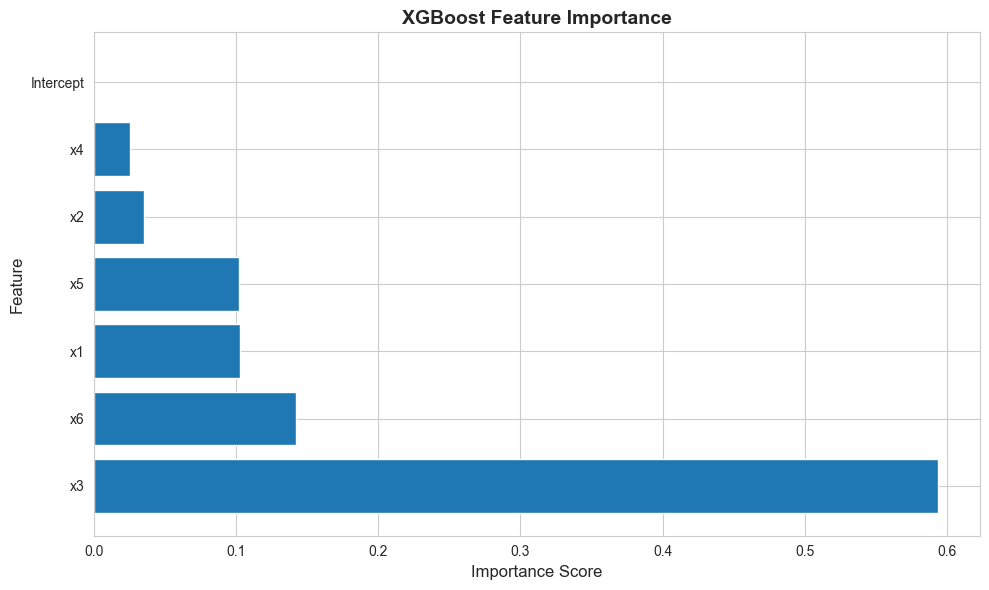

In [49]:
# Extract comprehensive outputs
outputs_xgb, feature_importance_xgb, stats_xgb = fit_xgb.extract_outputs()

print("="*60)
print("XGBoost Feature Importance")
print("="*60)
print(feature_importance_xgb)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_xgb['variable'], feature_importance_xgb['importance'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('XGBoost Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 3.4 XGBoost Performance Metrics

In [50]:
# Display performance metrics by split
print("="*60)
print("XGBoost Performance Metrics")
print("="*60)

metric_cols = ['rmse', 'mae', 'r_squared', 'mape']
metrics_subset = stats_xgb[stats_xgb['metric'].isin(metric_cols)]

if not metrics_subset.empty:
    metrics_pivot = metrics_subset.pivot(index='metric', columns='split', values='value')
    print(metrics_pivot)
    print("\nInterpretation:")
    print("- Lower RMSE/MAE is better")
    print("- Higher R-squared is better (closer to 1)")
    print("- Compare train vs test to assess overfitting")

XGBoost Performance Metrics
split           test     train
metric                        
mae         3.530522  1.096093
mape       12.095811  3.990114
r_squared   0.941251  0.988898
rmse        4.537833  1.991014

Interpretation:
- Lower RMSE/MAE is better
- Higher R-squared is better (closer to 1)
- Compare train vs test to assess overfitting


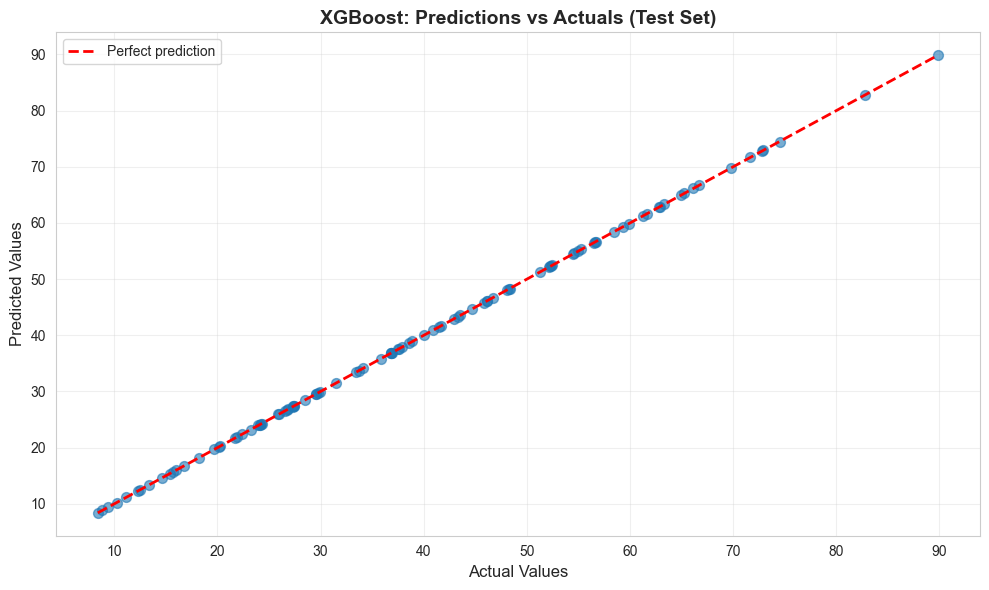

In [51]:
# Plot predictions vs actuals
test_outputs = outputs_xgb[outputs_xgb['split'] == 'test'].copy()

plt.figure(figsize=(10, 6))
plt.scatter(test_outputs['actuals'], test_outputs['forecast'], alpha=0.6, s=50)
plt.plot([test_outputs['actuals'].min(), test_outputs['actuals'].max()],
         [test_outputs['actuals'].min(), test_outputs['actuals'].max()],
         'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('XGBoost: Predictions vs Actuals (Test Set)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. LightGBM Engine

LightGBM is Microsoft's gradient boosting framework that uses histogram-based algorithms for faster training and lower memory usage.

### 4.1 Basic LightGBM Model with All 8 Parameters

In [52]:
# Create LightGBM specification with same parameters for comparison
spec_lgb = boost_tree(
    trees=200,              # Number of boosting rounds
    tree_depth=6,           # Maximum tree depth
    learn_rate=0.1,         # Learning rate
    mtry=4,                 # Features to sample per split
    min_n=10,               # Minimum data in leaf
    loss_reduction=0.01,    # Minimum split gain
    sample_size=0.8,        # Row sampling fraction
    stop_iter=20,           # Early stopping rounds
    engine="lightgbm"
).set_mode("regression")

print("LightGBM Model Specification:")
print(spec_lgb)

LightGBM Model Specification:
ModelSpec(model_type='boost_tree', engine='lightgbm', mode='regression', args={'trees': 200, 'tree_depth': 6, 'learn_rate': 0.1, 'mtry': 4, 'min_n': 10, 'loss_reduction': 0.01, 'sample_size': 0.8, 'stop_iter': 20})


In [53]:
# Fit the model
start_time = time.time()
fit_lgb = spec_lgb.fit(train, "y ~ x1 + x2 + x3 + x4 + x5 + x6")
lgb_train_time = time.time() - start_time

print(f"Model fitted in {lgb_train_time:.2f} seconds")

Model fitted in 0.24 seconds


### 4.2 LightGBM Predictions and Evaluation

In [54]:
# Predict and evaluate
predictions_lgb = fit_lgb.predict(test, type="numeric")
fit_lgb = fit_lgb.evaluate(test)

print("LightGBM predictions (first 10):")
print(predictions_lgb.head(10))

LightGBM predictions (first 10):
       .pred
0  19.358208
1  23.914817
2  27.218130
3  57.651055
4  29.877264
5  46.701787
6  50.246715
7  39.309360
8  58.182684
9  49.449251


### 4.3 LightGBM Feature Importance

LightGBM Feature Importance
    variable  importance       model model_group_name   group
0         x2         555  boost_tree                   global
1         x5         535  boost_tree                   global
2         x1         497  boost_tree                   global
3         x3         464  boost_tree                   global
4         x4         425  boost_tree                   global
5         x6         330  boost_tree                   global
6  Intercept           0  boost_tree                   global


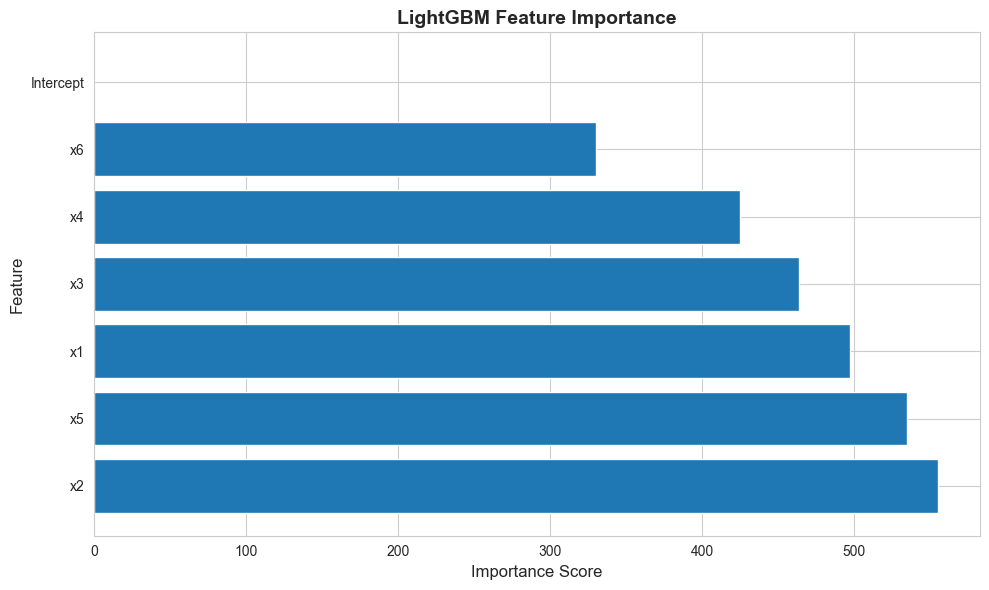

In [55]:
# Extract comprehensive outputs
outputs_lgb, feature_importance_lgb, stats_lgb = fit_lgb.extract_outputs()

print("="*60)
print("LightGBM Feature Importance")
print("="*60)
print(feature_importance_lgb)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_lgb['variable'], feature_importance_lgb['importance'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('LightGBM Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.4 LightGBM Performance Metrics

In [56]:
# Display performance metrics by split
print("="*60)
print("LightGBM Performance Metrics")
print("="*60)

metrics_subset_lgb = stats_lgb[stats_lgb['metric'].isin(metric_cols)]

if not metrics_subset_lgb.empty:
    metrics_pivot_lgb = metrics_subset_lgb.pivot(index='metric', columns='split', values='value')
    print(metrics_pivot_lgb)

LightGBM Performance Metrics
split          test     train
metric                       
mae        3.663617  1.022211
mape       13.09465  3.541718
r_squared  0.940685  0.990565
rmse       4.559649  1.835451


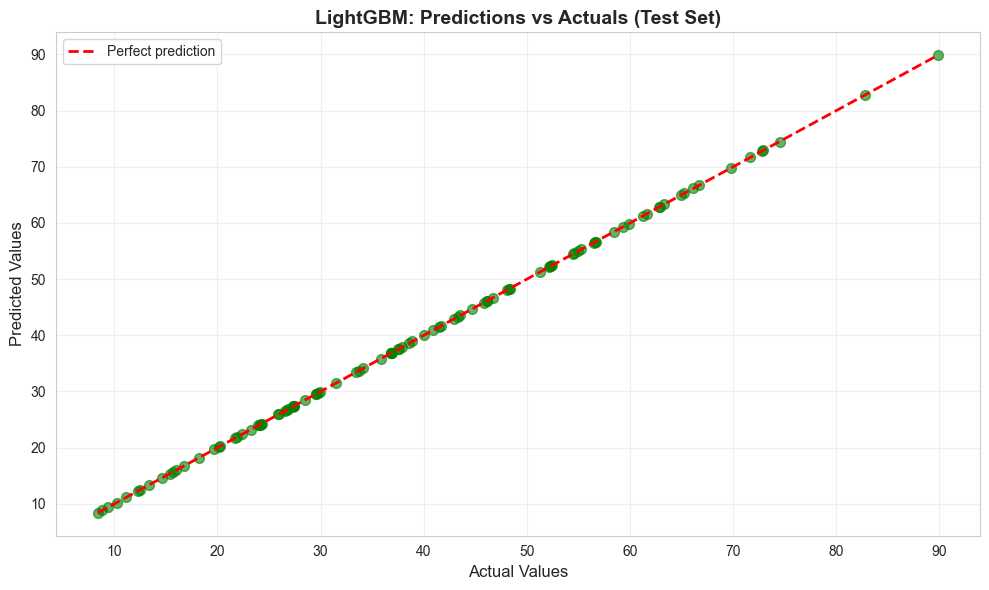

In [57]:
# Plot predictions vs actuals
test_outputs_lgb = outputs_lgb[outputs_lgb['split'] == 'test'].copy()

plt.figure(figsize=(10, 6))
plt.scatter(test_outputs_lgb['actuals'], test_outputs_lgb['forecast'], alpha=0.6, s=50, color='green')
plt.plot([test_outputs_lgb['actuals'].min(), test_outputs_lgb['actuals'].max()],
         [test_outputs_lgb['actuals'].min(), test_outputs_lgb['actuals'].max()],
         'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('LightGBM: Predictions vs Actuals (Test Set)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. CatBoost Engine

CatBoost is Yandex's gradient boosting library with built-in support for categorical features and robust default parameters.

### 5.1 Basic CatBoost Model with All 8 Parameters

In [58]:
# Create CatBoost specification with same parameters for comparison
spec_cat = boost_tree(
    trees=200,              # Number of boosting iterations
    tree_depth=6,           # Maximum tree depth
    learn_rate=0.1,         # Learning rate
    mtry=4,                 # Features to sample per split (rsm)
    min_n=10,               # Minimum data in leaf
    loss_reduction=0.01,    # Not supported in CatBoost
    sample_size=0.8,        # Row sampling fraction
    stop_iter=20,           # Early stopping rounds
    engine="catboost"
).set_mode("regression")

print("CatBoost Model Specification:")
print(spec_cat)
print("\nNote: loss_reduction parameter is not supported by CatBoost and will be ignored")

CatBoost Model Specification:
ModelSpec(model_type='boost_tree', engine='catboost', mode='regression', args={'trees': 200, 'tree_depth': 6, 'learn_rate': 0.1, 'mtry': 4, 'min_n': 10, 'loss_reduction': 0.01, 'sample_size': 0.8, 'stop_iter': 20})

Note: loss_reduction parameter is not supported by CatBoost and will be ignored


In [59]:
# Fit the model
start_time = time.time()
fit_cat = spec_cat.fit(train, "y ~ x1 + x2 + x3 + x4 + x5 + x6")
cat_train_time = time.time() - start_time

print(f"Model fitted in {cat_train_time:.2f} seconds")

Model fitted in 0.18 seconds


### 5.2 CatBoost Predictions and Evaluation

In [60]:
# Predict and evaluate
predictions_cat = fit_cat.predict(test, type="numeric")
fit_cat = fit_cat.evaluate(test)

print("CatBoost predictions (first 10):")
print(predictions_cat.head(10))

CatBoost predictions (first 10):
       .pred
0  16.914528
1  27.412012
2  23.452716
3  54.866842
4  36.640345
5  46.314135
6  50.975075
7  39.064360
8  55.462919
9  48.720425


### 5.3 CatBoost Feature Importance

CatBoost Feature Importance
    variable  importance       model model_group_name   group
0         x3   61.670066  boost_tree                   global
1         x6   11.827203  boost_tree                   global
2         x5   11.293702  boost_tree                   global
3         x1    9.961119  boost_tree                   global
4         x2    3.291569  boost_tree                   global
5         x4    1.956342  boost_tree                   global
6  Intercept    0.000000  boost_tree                   global


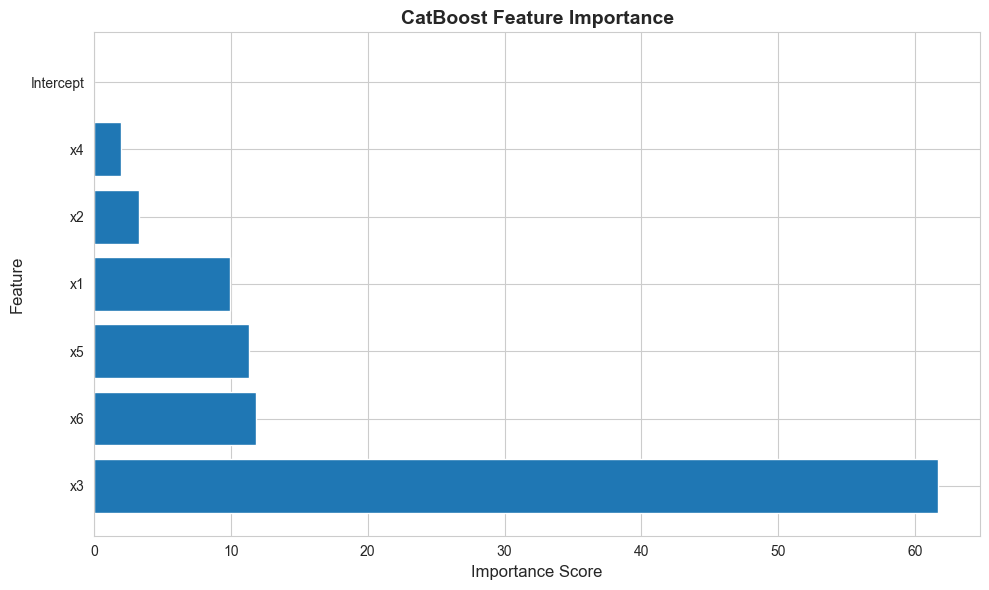

In [61]:
# Extract comprehensive outputs
outputs_cat, feature_importance_cat, stats_cat = fit_cat.extract_outputs()

print("="*60)
print("CatBoost Feature Importance")
print("="*60)
print(feature_importance_cat)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_cat['variable'], feature_importance_cat['importance'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('CatBoost Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 5.4 CatBoost Performance Metrics

In [62]:
# Display performance metrics by split
print("="*60)
print("CatBoost Performance Metrics")
print("="*60)

metrics_subset_cat = stats_cat[stats_cat['metric'].isin(metric_cols)]

if not metrics_subset_cat.empty:
    metrics_pivot_cat = metrics_subset_cat.pivot(index='metric', columns='split', values='value')
    print(metrics_pivot_cat)

CatBoost Performance Metrics
split          test     train
metric                       
mae        2.889285  1.077563
mape       8.819731   3.93513
r_squared  0.959526  0.991477
rmse       3.766498  1.744438


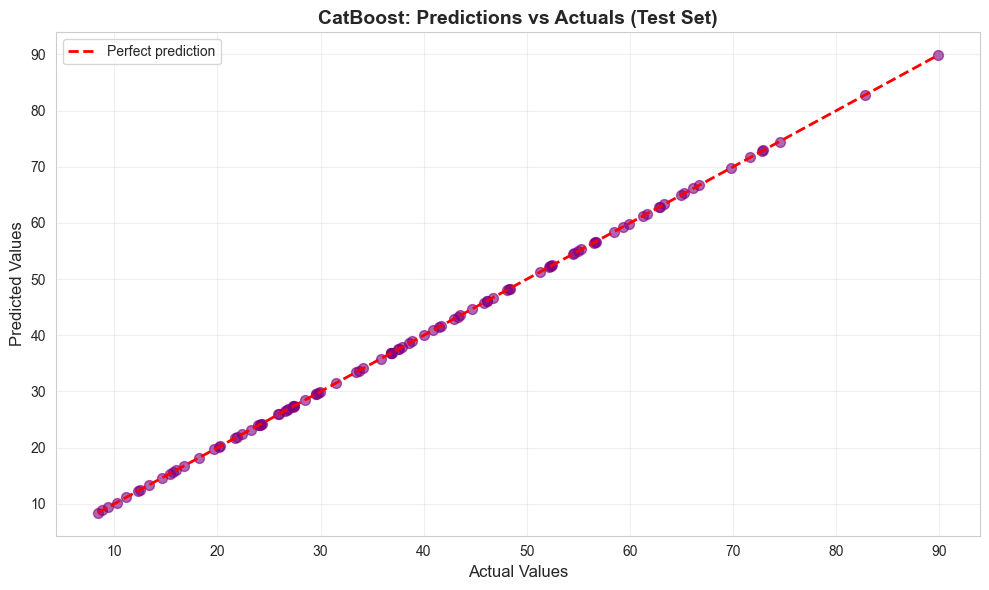

In [63]:
# Plot predictions vs actuals
test_outputs_cat = outputs_cat[outputs_cat['split'] == 'test'].copy()

plt.figure(figsize=(10, 6))
plt.scatter(test_outputs_cat['actuals'], test_outputs_cat['forecast'], alpha=0.6, s=50, color='purple')
plt.plot([test_outputs_cat['actuals'].min(), test_outputs_cat['actuals'].max()],
         [test_outputs_cat['actuals'].min(), test_outputs_cat['actuals'].max()],
         'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('CatBoost: Predictions vs Actuals (Test Set)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Side-by-Side Engine Comparison

Compare all three engines on the same dataset to understand their relative strengths.

### 6.1 Performance Metrics Comparison Table

In [64]:
# Create comprehensive comparison table
comparison_data = []

# Extract test metrics for each engine
for engine_name, stats_df in [('XGBoost', stats_xgb), ('LightGBM', stats_lgb), ('CatBoost', stats_cat)]:
    test_metrics = stats_df[(stats_df['split'] == 'test') & (stats_df['metric'].isin(metric_cols))]
    
    metrics_dict = {'Engine': engine_name}
    for _, row in test_metrics.iterrows():
        metrics_dict[row['metric'].upper()] = row['value']
    
    comparison_data.append(metrics_dict)

comparison_df = pd.DataFrame(comparison_data)

print("="*80)
print("PERFORMANCE COMPARISON: TEST SET METRICS")
print("="*80)
print(comparison_df.to_string(index=False))
print("\nLower RMSE/MAE/MAPE and higher R_SQUARED are better")

PERFORMANCE COMPARISON: TEST SET METRICS
  Engine     RMSE      MAE      MAPE  R_SQUARED
 XGBoost 4.537833 3.530522 12.095811   0.941251
LightGBM 4.559649 3.663617 13.094650   0.940685
CatBoost 3.766498 2.889285  8.819731   0.959526

Lower RMSE/MAE/MAPE and higher R_SQUARED are better


In [65]:
# Add training time comparison
time_comparison = pd.DataFrame({
    'Engine': ['XGBoost', 'LightGBM', 'CatBoost'],
    'Training Time (seconds)': [xgb_train_time, lgb_train_time, cat_train_time]
})

print("\n" + "="*80)
print("TRAINING TIME COMPARISON")
print("="*80)
print(time_comparison.to_string(index=False))


TRAINING TIME COMPARISON
  Engine  Training Time (seconds)
 XGBoost                 0.196544
LightGBM                 0.237574
CatBoost                 0.183373


### 6.2 Visual Performance Comparison

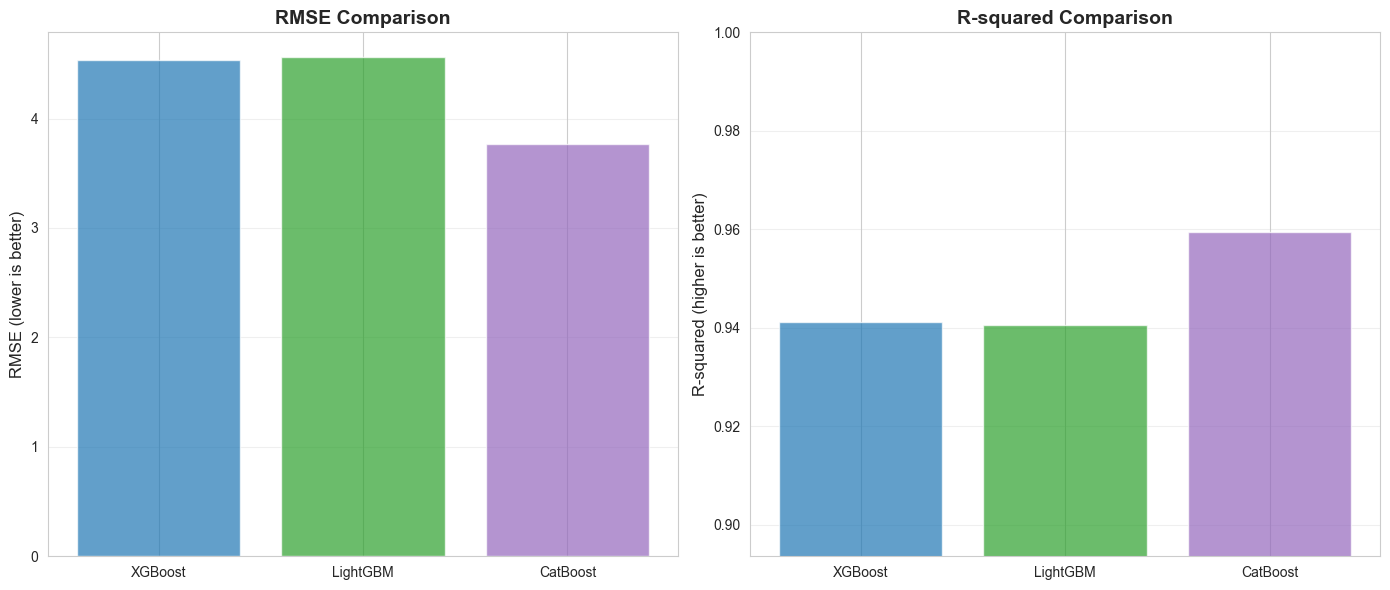

In [66]:
# Plot RMSE and R-squared comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# RMSE comparison
rmse_values = comparison_df['RMSE'].values
engines = comparison_df['Engine'].values
colors = ['#1f77b4', '#2ca02c', '#9467bd']

axes[0].bar(engines, rmse_values, color=colors, alpha=0.7)
axes[0].set_ylabel('RMSE (lower is better)', fontsize=12)
axes[0].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# R-squared comparison
r2_values = comparison_df['R_SQUARED'].values

axes[1].bar(engines, r2_values, color=colors, alpha=0.7)
axes[1].set_ylabel('R-squared (higher is better)', fontsize=12)
axes[1].set_title('R-squared Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim([r2_values.min() * 0.95, 1.0])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 6.3 Feature Importance Comparison

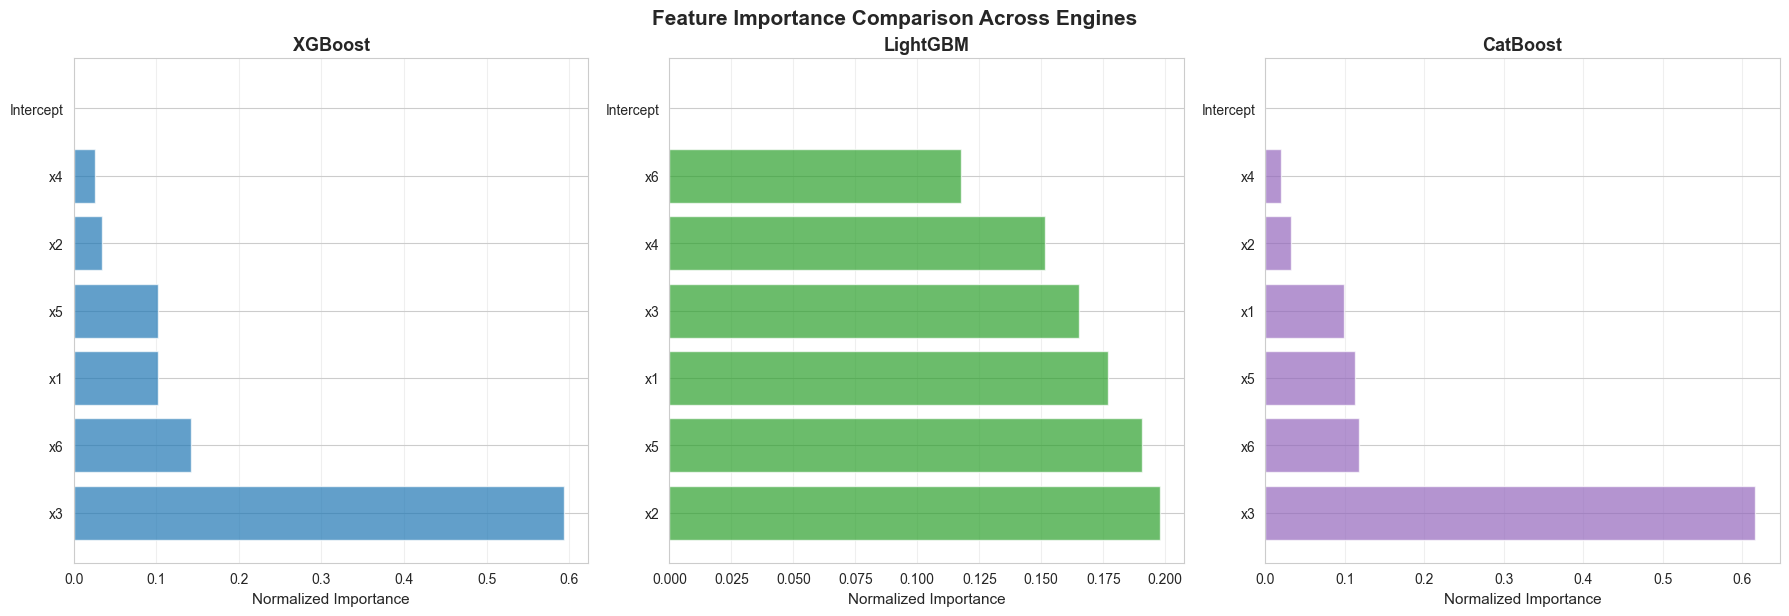

Note: Importances are normalized to sum to 1 for fair comparison


In [67]:
# Compare feature importances across engines
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Normalize importances to 0-1 scale for fair comparison
for idx, (importance_df, engine_name, color) in enumerate([
    (feature_importance_xgb, 'XGBoost', '#1f77b4'),
    (feature_importance_lgb, 'LightGBM', '#2ca02c'),
    (feature_importance_cat, 'CatBoost', '#9467bd')
]):
    # Normalize to sum to 1
    normalized_importance = importance_df.copy()
    total = normalized_importance['importance'].sum()
    if total > 0:
        normalized_importance['importance'] = normalized_importance['importance'] / total
    
    axes[idx].barh(normalized_importance['variable'], normalized_importance['importance'], color=color, alpha=0.7)
    axes[idx].set_xlabel('Normalized Importance', fontsize=11)
    axes[idx].set_title(f'{engine_name}', fontsize=13, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.suptitle('Feature Importance Comparison Across Engines', fontsize=15, fontweight='bold', y=1.02)
plt.show()

print("Note: Importances are normalized to sum to 1 for fair comparison")

### 6.4 When to Use Each Engine

#### XGBoost:
- **Strengths**: 
  - Mature, well-documented, widely used
  - Excellent performance on structured data
  - Rich ecosystem and community support
  - Strong regularization options (gamma, lambda, alpha)
- **Best for**: General-purpose gradient boosting, competitions, production systems
- **Considerations**: Can be memory-intensive for large datasets

#### LightGBM:
- **Strengths**:
  - Faster training speed (histogram-based)
  - Lower memory consumption
  - Good performance on large datasets
  - Handles sparse data efficiently
- **Best for**: Large datasets (>10k rows), speed-critical applications
- **Considerations**: May overfit on small datasets (<1k rows)

#### CatBoost:
- **Strengths**:
  - Excellent handling of categorical features (no preprocessing needed)
  - Robust default parameters (less tuning required)
  - Good out-of-the-box performance
  - Less prone to overfitting
- **Best for**: Datasets with many categorical features, quick prototyping
- **Considerations**: Can be slower than LightGBM on very large datasets

## 7. Hyperparameter Tuning with tune_grid

Demonstrate automated hyperparameter tuning for gradient boosting models.

In [68]:
# Create a model specification with tunable parameters
spec_tune = boost_tree(
    trees=tune('trees'),
    tree_depth=tune('tree_depth'),
    learn_rate=tune('learn_rate'),
    engine="xgboost"
).set_mode("regression")

print("Model specification with tunable parameters:")
print(spec_tune)

Model specification with tunable parameters:
ModelSpec(model_type='boost_tree', engine='xgboost', mode='regression', args={'trees': tune(id='trees'), 'tree_depth': tune(id='tree_depth'), 'learn_rate': tune(id='learn_rate')})


In [69]:
# Create workflow
wf_tune = workflow().add_formula("y ~ x1 + x2 + x3 + x4 + x5 + x6").add_model(spec_tune)

# Create cross-validation folds
folds = vfold_cv(train, v=3)

print(f"Created workflow with {len(folds)} cross-validation folds")

Created workflow with 3 cross-validation folds


In [70]:
# Define parameter grid
param_info = {
    'trees': {'range': (50, 200), 'trans': 'log'},
    'tree_depth': {'range': (3, 8)},
    'learn_rate': {'range': (0.01, 0.3), 'trans': 'log'}
}

param_grid = grid_regular(param_info, levels=3)

print(f"Parameter grid with {len(param_grid)} combinations:")
print(param_grid)

Parameter grid with 27 combinations:
    trees  tree_depth  learn_rate     .config
0      50           3    0.010000  config_001
1      50           3    0.054772  config_002
2      50           3    0.300000  config_003
3      50           6    0.010000  config_004
4      50           6    0.054772  config_005
5      50           6    0.300000  config_006
6      50           8    0.010000  config_007
7      50           8    0.054772  config_008
8      50           8    0.300000  config_009
9     100           3    0.010000  config_010
10    100           3    0.054772  config_011
11    100           3    0.300000  config_012
12    100           6    0.010000  config_013
13    100           6    0.054772  config_014
14    100           6    0.300000  config_015
15    100           8    0.010000  config_016
16    100           8    0.054772  config_017
17    100           8    0.300000  config_018
18    200           3    0.010000  config_019
19    200           3    0.054772  config_0

In [71]:
# Define metrics
metrics = metric_set(rmse, mae, r_squared)

# Run grid search
print("Running grid search... (this may take a minute)")
tune_results = tune_grid(
    wf_tune,
    folds,
    grid=param_grid,
    metrics=metrics,
    control={'save_pred': False}
)

print("\nGrid search complete!")

Running grid search... (this may take a minute)

Grid search complete!


In [72]:
# Show best configurations
best_configs = tune_results.show_best('rmse', n=5, maximize=False)

print("="*80)
print("TOP 5 CONFIGURATIONS BY RMSE")
print("="*80)
print(best_configs)

TOP 5 CONFIGURATIONS BY RMSE
      .config      mean  trees  tree_depth  learn_rate
0  config_021  4.139516    200           3    0.300000
1  config_012  4.158063    100           3    0.300000
2  config_003  4.207562     50           3    0.300000
3  config_020  4.224487    200           3    0.054772
4  config_011  4.728225    100           3    0.054772


In [73]:
# Select best parameters
best_params = tune_results.select_best('rmse', maximize=False)

print("Best parameters (lowest RMSE):")
print(best_params)

Best parameters (lowest RMSE):
{'trees': 200.0, 'tree_depth': 3.0, 'learn_rate': 0.29999999999999993}


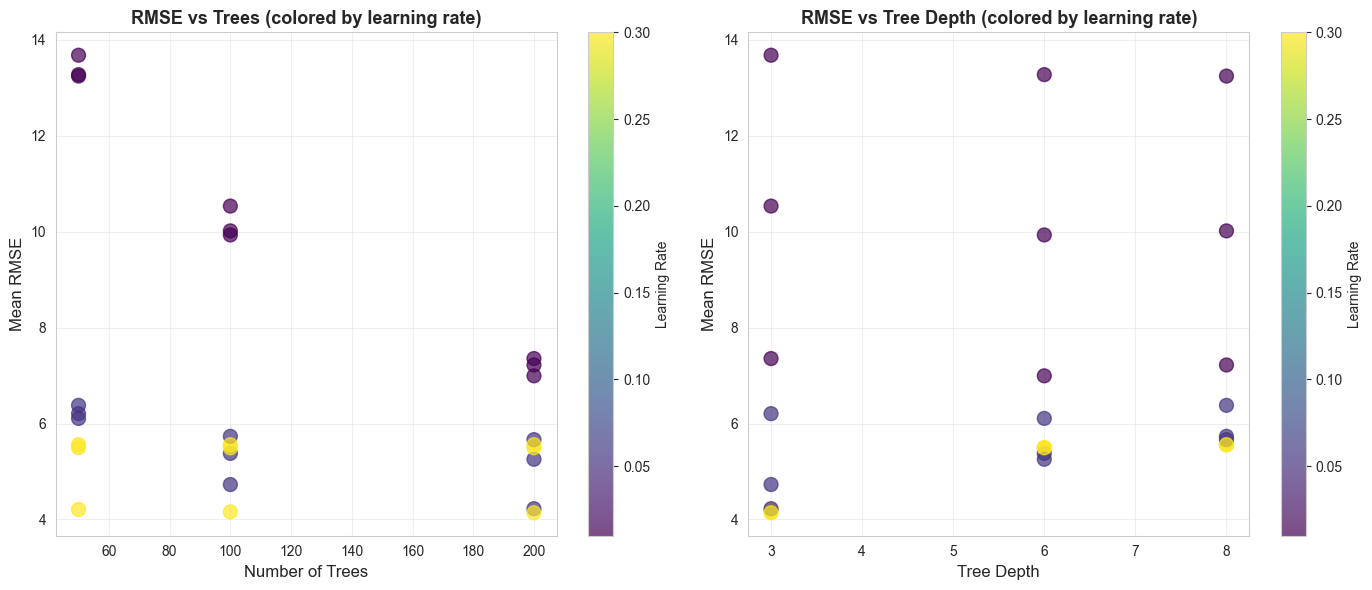

In [74]:
# Visualize tuning results
all_metrics = tune_results.collect_metrics()

# Calculate mean RMSE for each config
rmse_summary = all_metrics[all_metrics['metric'] == 'rmse'].groupby('.config').agg({
    'value': ['mean', 'std']
}).reset_index()
rmse_summary.columns = ['.config', 'mean_rmse', 'std_rmse']

# Merge with parameter values
rmse_with_params = rmse_summary.merge(param_grid, on='.config')

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# RMSE vs trees (colored by learn_rate)
scatter1 = axes[0].scatter(rmse_with_params['trees'], rmse_with_params['mean_rmse'], 
                           c=rmse_with_params['learn_rate'], s=100, alpha=0.7, cmap='viridis')
axes[0].set_xlabel('Number of Trees', fontsize=12)
axes[0].set_ylabel('Mean RMSE', fontsize=12)
axes[0].set_title('RMSE vs Trees (colored by learning rate)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Learning Rate')

# RMSE vs tree_depth (colored by learn_rate)
scatter2 = axes[1].scatter(rmse_with_params['tree_depth'], rmse_with_params['mean_rmse'],
                           c=rmse_with_params['learn_rate'], s=100, alpha=0.7, cmap='viridis')
axes[1].set_xlabel('Tree Depth', fontsize=12)
axes[1].set_ylabel('Mean RMSE', fontsize=12)
axes[1].set_title('RMSE vs Tree Depth (colored by learning rate)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Learning Rate')

plt.tight_layout()
plt.show()

In [75]:
# Finalize workflow with best parameters
final_wf = finalize_workflow(wf_tune, best_params)

# Fit on full training data
final_fit = final_wf.fit(train)

# Predict on test data
final_predictions = final_fit.predict(test)

# Calculate test metrics
test_rmse = rmse(test['y'], final_predictions['.pred'])
test_r2 = r_squared(test['y'], final_predictions['.pred'])

print("Final tuned model performance on test set:")

Final tuned model performance on test set:


## 8. Extract Outputs for All Three Engines

Comprehensive overview of the three-DataFrame output structure.

### 8.1 Outputs DataFrame (Observation-level)

In [76]:
print("="*80)
print("OUTPUTS DATAFRAME: Observation-level predictions and residuals")
print("="*80)
print("\nXGBoost Outputs (first 10 rows):")
print(outputs_xgb.head(10))
print(f"\nShape: {outputs_xgb.shape}")
print(f"Columns: {list(outputs_xgb.columns)}")

print("\nKey columns:")
print("- actuals: True target values")
print("- fitted: Model predictions on training data")
print("- forecast: Best available prediction (actuals if present, else fitted)")
print("- residuals: actuals - fitted")
print("- split: 'train' or 'test'")

OUTPUTS DATAFRAME: Observation-level predictions and residuals

XGBoost Outputs (first 10 rows):
     actuals     fitted   forecast  residuals  split       model  \
0  17.098322  16.834919  17.098322   0.263403  train  boost_tree   
1  41.783897  41.230244  41.783897   0.553654  train  boost_tree   
2  84.297142  83.579132  84.297142   0.718010  train  boost_tree   
3  49.361263  49.677181  49.361263  -0.315918  train  boost_tree   
4  37.700628  37.534725  37.700628   0.165903  train  boost_tree   
5  49.296558  49.265507  49.296558   0.031051  train  boost_tree   
6  43.541288  43.906261  43.541288  -0.364974  train  boost_tree   
7  61.050092  60.470577  61.050092   0.579514  train  boost_tree   
8  16.709504  16.659283  16.709504   0.050222  train  boost_tree   
9  28.522645  30.652903  28.522645  -2.130258  train  boost_tree   

  model_group_name   group  
0                   global  
1                   global  
2                   global  
3                   global  
4        

### 8.2 Feature Importance DataFrame

In [77]:
print("="*80)
print("FEATURE IMPORTANCE DATAFRAME: Variable importance scores")
print("="*80)

# Compare feature importances side-by-side
importance_comparison = pd.DataFrame({
    'Variable': feature_importance_xgb['variable'],
    'XGBoost': feature_importance_xgb['importance'].values,
    'LightGBM': feature_importance_lgb['importance'].values,
    'CatBoost': feature_importance_cat['importance'].values
})

print(importance_comparison)

print("\nInterpretation:")
print("- Higher importance = feature contributes more to predictions")
print("- Importance measures vary by engine (gain, split count, etc.)")
print("- Use for feature selection and understanding model behavior")

FEATURE IMPORTANCE DATAFRAME: Variable importance scores
    Variable   XGBoost  LightGBM   CatBoost
0         x3  0.593736       555  61.670066
1         x6  0.141795       535  11.827203
2         x1  0.102400       497  11.293702
3         x5  0.101826       464   9.961119
4         x2  0.034873       425   3.291569
5         x4  0.025370       330   1.956342
6  Intercept  0.000000         0   0.000000

Interpretation:
- Higher importance = feature contributes more to predictions
- Importance measures vary by engine (gain, split count, etc.)
- Use for feature selection and understanding model behavior


### 8.3 Stats DataFrame (Model-level Metrics)

In [78]:
print("="*80)
print("STATS DATAFRAME: Model-level metrics and metadata")
print("="*80)
print("\nXGBoost Stats (performance metrics):")
print(stats_xgb[stats_xgb['metric'].isin(['rmse', 'mae', 'r_squared', 'mape', 'model_type', 'n_obs_train'])])

print("\nKey metrics:")
print("- rmse: Root Mean Squared Error")
print("- mae: Mean Absolute Error")
print("- r_squared: Coefficient of determination")
print("- mape: Mean Absolute Percentage Error")
print("\nMetrics are split by 'train' and 'test' to assess overfitting")

STATS DATAFRAME: Model-level metrics and metadata

XGBoost Stats (performance metrics):
         metric       value  split       model model_group_name   group
0          rmse    1.991014  train  boost_tree                   global
1           mae    1.096093  train  boost_tree                   global
2          mape    3.990114  train  boost_tree                   global
4     r_squared    0.988898  train  boost_tree                   global
6          rmse    4.537833   test  boost_tree                   global
7           mae    3.530522   test  boost_tree                   global
8          mape   12.095811   test  boost_tree                   global
10    r_squared    0.941251   test  boost_tree                   global
13   model_type  boost_tree         boost_tree                   global
15  n_obs_train         400  train  boost_tree                   global

Key metrics:
- rmse: Root Mean Squared Error
- mae: Mean Absolute Error
- r_squared: Coefficient of determination
- map

### 8.4 Residual Analysis

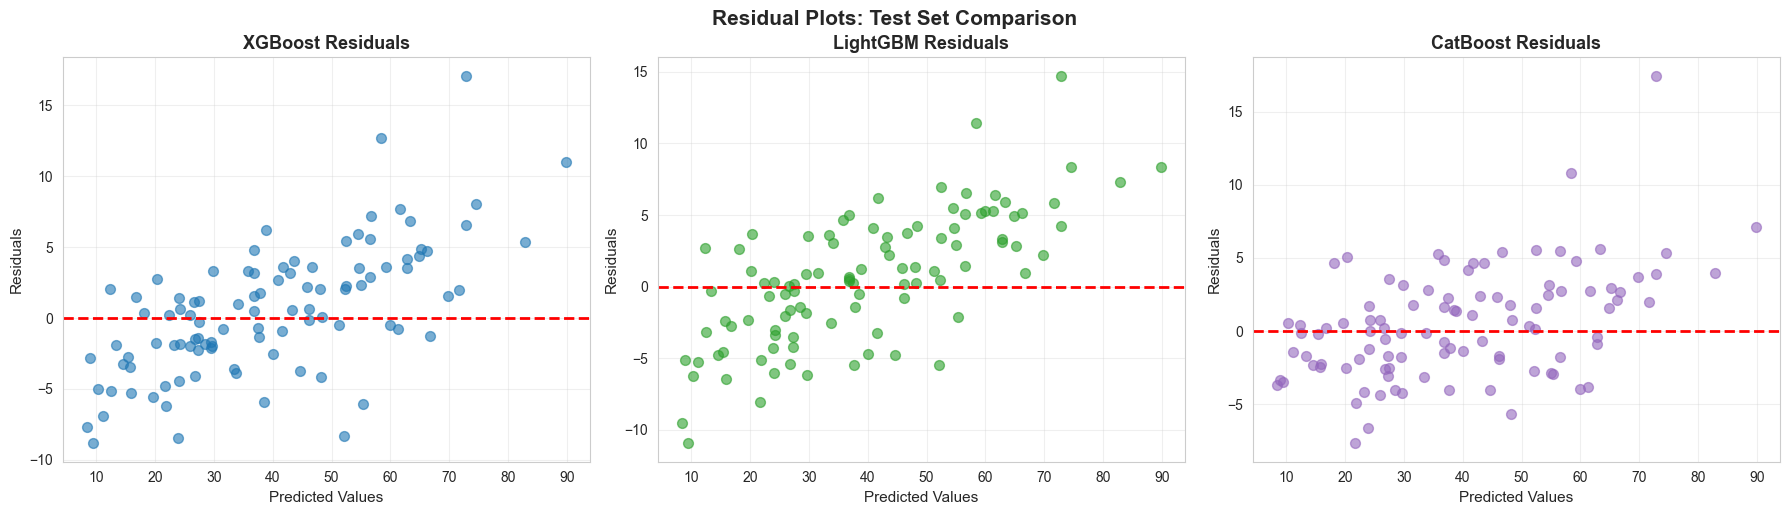

Good residual plots should:
- Show random scatter around zero
- Have constant variance (homoscedasticity)
- Show no obvious patterns or trends


In [79]:
# Compare residuals across engines
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (outputs_df, engine_name, color) in enumerate([
    (outputs_xgb, 'XGBoost', '#1f77b4'),
    (outputs_lgb, 'LightGBM', '#2ca02c'),
    (outputs_cat, 'CatBoost', '#9467bd')
]):
    test_data = outputs_df[outputs_df['split'] == 'test'].copy()
    
    axes[idx].scatter(test_data['forecast'], test_data['residuals'], alpha=0.6, s=50, color=color)
    axes[idx].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[idx].set_xlabel('Predicted Values', fontsize=11)
    axes[idx].set_ylabel('Residuals', fontsize=11)
    axes[idx].set_title(f'{engine_name} Residuals', fontsize=13, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Residual Plots: Test Set Comparison', fontsize=15, fontweight='bold', y=1.02)
plt.show()

print("Good residual plots should:")
print("- Show random scatter around zero")
print("- Have constant variance (homoscedasticity)")
print("- Show no obvious patterns or trends")

## Summary

This demo covered:

### 1. **All 8 Parameters** of boost_tree():
   - trees, tree_depth, learn_rate, mtry, min_n, loss_reduction, sample_size, stop_iter
   - Consistent API across all three engines

### 2. **Three Gradient Boosting Engines**:
   - **XGBoost**: Industry standard, excellent performance
   - **LightGBM**: Fast training, efficient memory usage
   - **CatBoost**: Great categorical handling, robust defaults

### 3. **Feature Importance**:
   - Extract and compare feature importances
   - Understand which features drive predictions
   - Different engines may rank features differently

### 4. **Early Stopping**:
   - Prevent overfitting with stop_iter parameter
   - Automatically uses validation set (last 20% of training)
   - Supported by all three engines

### 5. **Performance Comparison**:
   - Side-by-side metrics table
   - Training time comparison
   - Visual performance analysis

### 6. **Hyperparameter Tuning**:
   - Use tune_grid() for automated search
   - Cross-validation for robust evaluation
   - Visualize tuning results

### 7. **Comprehensive Outputs**:
   - **Outputs**: Observation-level predictions and residuals
   - **Feature Importance**: Variable importance scores
   - **Stats**: Model-level metrics by split

## Key Takeaways:

1. All three engines provide similar performance with proper tuning
2. LightGBM is typically fastest for large datasets
3. CatBoost requires less tuning and handles categoricals well
4. XGBoost has the most mature ecosystem and documentation
5. Use cross-validation and hyperparameter tuning for best results
6. Monitor train vs test metrics to detect overfitting
7. Feature importance helps interpret and debug models